# Compare latent space to high-dimensional space

In [2]:
import os
import pandas as pd
import sys
import numpy as np
from pandas.core.common import flatten
import pickle
import umap
from pathlib import Path
import datetime
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [3]:
from preprocessing_functions import pad_spectro, calc_zscore, create_padded_data
from evaluation_functions import get_knn, make_nn_stats_dict, make_statstabs

In [4]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures")

In [5]:
dftype = "reduced"
spec_df = pd.read_pickle(os.path.join(os.path.sep, DATA, "df_focal_"+dftype+".pkl"))

labels = spec_df.call_lable.values
calltypes = sorted(list(set(labels)))

specs = spec_df.spectrograms
specs = [calc_zscore(x) for x in specs]
original_embedding = create_padded_data(specs)

## Compare embedding score S for different k's

In [20]:
# Make 5 UMAPs

n_times=5
embeddings_dict={}
for i in range(n_times):
    reducer = umap.UMAP(min_dist=0, metric= "euclidean", n_components = 3)
    embeddings_dict[i] = reducer.fit_transform(original_embedding)
  

In [30]:
# UMAP space

#ks = [1,3,5,8,10,15,20,30,40]
ks = [1,3,5,8,10,15,20,30,40,50,100,200]

metrics_tab = np.zeros((len(ks)*n_times,2))

i=0
for embedding in embeddings_dict.values():
    indices, distances = get_knn(np.max(np.asarray(ks)),embedding)
    for k_num,k in enumerate(ks):
        these_indices = [x[0:k] for x in indices]
        nn_stats_dict = make_nn_stats_dict(calltypes, labels, these_indices)
        stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels, k)

        metrics_tab[i,0] = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
        metrics_tab[i,1] = np.mean(np.diagonal(stats_tab_norm))
        i+=1
        
metrics_tab_df = pd.DataFrame(metrics_tab)
metrics_tab_df['k'] = ks*n_times
metrics_tab_df.columns = ['S', 'Snorm', 'k']

means_df = metrics_tab_df.groupby('k').mean()
stds_df = metrics_tab_df.groupby('k').std()


# Original space

metrics_tab_f = np.zeros((len(ks),2))

indices, distances = get_knn(np.max(np.asarray(ks)),original_embedding)

for k_num,k in enumerate(ks):
    these_indices = [x[0:k] for x in indices]
    nn_stats_dict = make_nn_stats_dict(calltypes, labels, these_indices)
    stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels,k)

    metrics_tab_f[k_num,0] = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
    metrics_tab_f[k_num,1] = np.mean(np.diagonal(stats_tab_norm))

metrics_tab_f_df = pd.DataFrame(metrics_tab_f)
metrics_tab_f_df['k'] = ks
metrics_tab_f_df.columns = ['S', 'Snorm', 'k']

In [31]:
# Original space

metrics_tab_f = np.zeros((len(ks),2))

indices, distances = get_knn(np.max(np.asarray(ks)),original_embedding)

for k_num,k in enumerate(ks):
    these_indices = [x[0:k] for x in indices]
    nn_stats_dict = make_nn_stats_dict(calltypes, labels, these_indices)
    stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels,k)

    metrics_tab_f[k_num,0] = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
    metrics_tab_f[k_num,1] = np.mean(np.diagonal(stats_tab_norm))

metrics_tab_f_df = pd.DataFrame(metrics_tab_f)
metrics_tab_f_df['k'] = ks
metrics_tab_f_df.columns = ['S', 'Snorm', 'k']

In [36]:
metrics_tab_f_df

,S,Snorm,k
0,70.685514,2.607156,1
1,67.492631,2.511618,3
2,65.586885,2.451023,5
3,63.885232,2.400733,8
4,62.943168,2.369164,10
5,60.973041,2.303188,15
6,59.706087,2.262391,20
7,57.469740,2.182281,30
8,55.728498,2.119245,40
9,54.406875,2.067839,50


In [37]:
means_df

,S,Snorm
k,,
1,63.842204,2.420716
3,62.344555,2.372834
5,61.605483,2.347721
8,60.591908,2.311939
10,60.121462,2.295688
15,59.270318,2.264199
20,58.597530,2.237855
30,57.394609,2.199427
40,56.457747,2.166019


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/2021-07-08_comparison_to_original.jpg


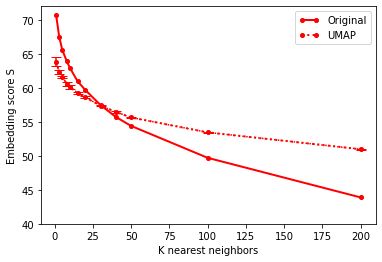

In [35]:
var ='S'

plt.plot(ks, metrics_tab_f_df[var], marker='o',linewidth=2, markersize=4, color ='red',label='Original')

plt.plot(ks, means_df[var], color = 'red', marker='o', linestyle='dotted', linewidth=2, markersize=4,label='UMAP')
plt.errorbar(ks, means_df[var], yerr=stds_df[var], linestyle='dotted', capsize=5, color = 'red')


plt.legend(numpoints=2)

plt.ylabel('Embedding score '+var)
plt.xlabel('K nearest neighbors')
plt.ylim(40,72)
outname=os.path.join(os.path.sep, FIGURES, datetime.datetime.today().strftime('%Y-%m-%d')+'_comparison_to_original.jpg')
print(outname)
plt.savefig(outname)

## Original space evaluation matrix

In [7]:
from evaluation_functions import nn, sil

In [8]:
nn_stats = nn(original_embedding, np.asarray(labels), k=5)

In [12]:
print("Log final metric (unweighted):",nn_stats.get_S())
print("Abs final metric (unweighted):",nn_stats.get_Snorm())

Log final metric (unweighted): 65.58688511753121
Abs final metric (unweighted): 2.4510227163786245


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/heatS_UMAP_reduced_original.png


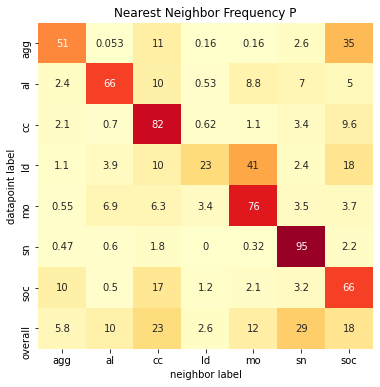

In [11]:
outname = os.path.join(os.path.sep, FIGURES, 'heatS_UMAP_'+dftype+'_original.png')
print(outname)
nn_stats.plot_heat_S(outname=outname)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/heatSnorm_UMAP_reduced_original.png


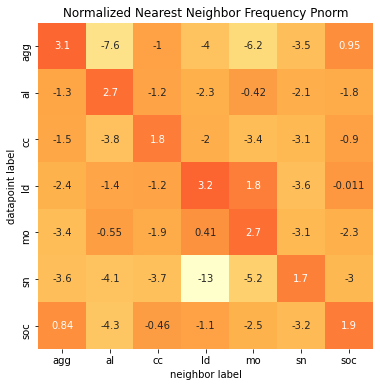

In [13]:
outname = os.path.join(os.path.sep, FIGURES, 'heatSnorm_UMAP_'+dftype+'_original.png')
print(outname)
nn_stats.plot_heat_Snorm(outname=outname)

## Original space Silhouette plot

In [38]:
sil_stats = sil(original_embedding, labels)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/silplot_UMAP_reduced_original.png


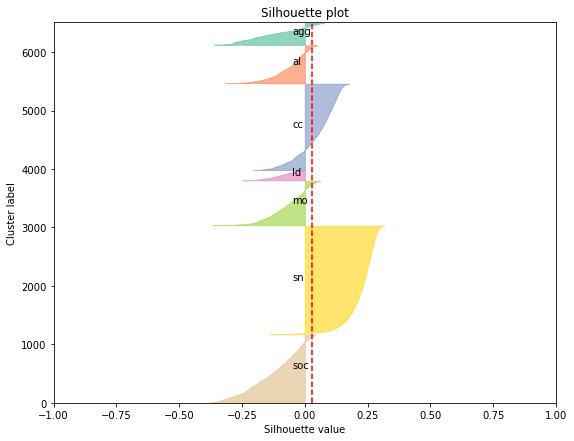

In [39]:
outname = os.path.join(os.path.sep, FIGURES, 'silplot_UMAP_'+dftype+'_original.png')

print(outname)
sil_stats.plot_sil(outname=outname)

In [40]:
sil_stats.get_avrg_score()

0.0298155402510341

## Original space between and within distances

In [5]:
from scipy.spatial.distance import pdist, squareform

In [6]:
distmat_original = squareform(pdist(original_embedding, metric='euclidean'))
labels = np.asarray(labels)

self_dists={}
other_dists={}

for calltype in calltypes:
    x=distmat_original[np.where(labels==calltype)]
    x = np.transpose(x)  
    y = x[np.where(labels==calltype)]
   
    self_dists[calltype] = y[np.triu_indices(n=y.shape[0], m=y.shape[1],k = 1)]
    y = x[np.where(labels!=calltype)]
    other_dists[calltype] = y[np.triu_indices(n=y.shape[0], m=y.shape[1], k = 1)]

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/2021-06-08_distanceswithinwithout_reduced_original.jpg


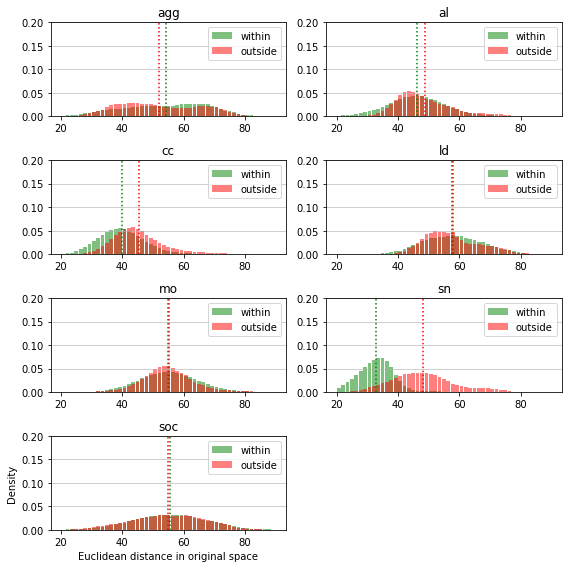

In [63]:
plt.figure(figsize=(8, 8))
i=1

xmin=20
xmax=90
nbins=50
    
for calltype in calltypes:
    
    plt.subplot(4, 2, i)
    n, bins, patches = plt.hist(x=self_dists[calltype], label="within", density=True,
                              #bins='auto', color='green',
                              bins=np.linspace(xmin, xmax, nbins), color='green',
                              alpha=0.5, rwidth=0.85)
    
    plt.vlines(x=np.mean(self_dists[calltype]),ymin=0,ymax=0.5,color='green', linestyles='dotted')

    n, bins, patches = plt.hist(x=other_dists[calltype], label="outside", density=True,
                              bins=np.linspace(xmin, xmax, nbins), color='red',
                              #bins='auto', color='red',
                              alpha=0.5, rwidth=0.85)
  
    plt.vlines(x=np.mean(other_dists[calltype]),ymin=0,ymax=0.5,color='red', linestyles='dotted')
  
    s, pval = scipy.stats.ttest_ind(self_dists[calltype],other_dists[calltype])

    if pval<0.01:
        pval = "p<0.01"
    else:
        pval = "p="+str(round(pval,2))

    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    #plt.title(calltype+" ("+pval+")")
    plt.title(calltype)
    #plt.xlim(xmin,xmax)
    plt.ylim(0, 0.2)
    if i==len(calltypes):      
        plt.ylabel('Density')
        plt.xlabel('Euclidean distance in original space')

    i=i+1

plt.tight_layout()
outname=os.path.join(os.path.sep, FIGURES, 'distanceswithinwithout_reduced_original.jpg')
print(outname)
plt.savefig(outname)

In [1]:
# Nearest neighbor preservation

In [7]:
from evaluation_functions import get_knn

In [6]:
embedding_filename = os.path.join(os.path.sep, DATA,'basic_UMAP_3D_'+dftype+'_default_params.csv')
print(embedding_filename)
embedding = np.loadtxt(embedding_filename, delimiter=";")

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/basic_UMAP_3D_reduced_default_params.csv


In [30]:
k=10
indices, distances = get_knn(k,embedding)
indices_original, distance_original = get_knn(k, original_embedding)

In [11]:
indices.shape

(6430, 5)

In [12]:
indices_original.shape

(6430, 5)

In [13]:
np.sum(indices == indices_original)

2083

In [32]:
for k in [1,2,3,4,5,6,7,8,9,10,15,20,30]:
    indices, distances = get_knn(k,embedding)
    indices_original, distance_original = get_knn(k, original_embedding)

    count_agree = 0
    count_disagree = 0

    for i in range(indices_original.shape[0]):
        for j in range(indices_original.shape[1]):
            if (indices_original[i,j] in indices[i,:]):
                count_agree += 1
            else:
                count_disagree += 1
    
    print(k, ": ", count_agree, "/", count_disagree)
    print(k, ": ", count_agree/(count_agree+count_disagree))    

1 :  971 / 5459
1 :  0.1510108864696734
2 :  2642 / 10218
2 :  0.20544323483670296
3 :  4455 / 14835
3 :  0.23094867807153965
4 :  6344 / 19376
4 :  0.24665629860031105
5 :  8325 / 23825
5 :  0.25894245723172626
6 :  10366 / 28214
6 :  0.26868843960601346
7 :  12432 / 32578
7 :  0.27620528771384134
8 :  14508 / 36932
8 :  0.28203732503888024
9 :  16721 / 41149
9 :  0.288940729220667
10 :  18922 / 45378
10 :  0.2942768273716952
15 :  29942 / 66508
15 :  0.310440642820114
20 :  41009 / 87591
20 :  0.31888802488335927
30 :  64039 / 128861
30 :  0.3319803006739243


In [34]:
for k in [50,100]:
    indices, distances = get_knn(k,embedding)
    indices_original, distance_original = get_knn(k, original_embedding)

    count_agree = 0
    count_disagree = 0

    for i in range(indices_original.shape[0]):
        for j in range(indices_original.shape[1]):
            if (indices_original[i,j] in indices[i,:]):
                count_agree += 1
            else:
                count_disagree += 1
    
    print(k, ": ", count_agree, "/", count_disagree)
    print(k, ": ", count_agree/(count_agree+count_disagree))    

50 :  112385 / 209115
50 :  0.34956454121306374
100 :  245670 / 397330
100 :  0.38206842923794715


In [36]:
for k in [1,2,3,4,5,6,7,8,9,10,15,20,30, 50, 100]:
    indices, distances = get_knn(k*2,embedding)
    indices_original, distance_original = get_knn(k, original_embedding)

    count_agree = 0
    count_disagree = 0

    for i in range(indices_original.shape[0]):
        for j in range(indices_original.shape[1]):
            if (indices_original[i,j] in indices[i,:]):
                count_agree += 1
            else:
                count_disagree += 1
    
    print(k, ": ", count_agree, "/", count_disagree)
    print(k, ": ", count_agree/(k*original_embedding.shape[0]))  

1 :  1678 / 4752
1 :  0.2609642301710731
2 :  4248 / 8612
2 :  0.33032659409020215
3 :  6972 / 12318
3 :  0.3614307931570762
4 :  9771 / 15949
4 :  0.37989891135303266
5 :  12743 / 19407
5 :  0.3963608087091757
6 :  15723 / 22857
6 :  0.40754276827371694
7 :  18790 / 26220
7 :  0.417462786047545
8 :  21919 / 29521
8 :  0.4261080870917574
9 :  24959 / 32911
9 :  0.43129428028339384
10 :  28034 / 36266
10 :  0.4359875583203732
15 :  43745 / 52705
15 :  0.45355106272680146
20 :  59504 / 69096
20 :  0.462706065318818
30 :  93004 / 99896
30 :  0.48213582166925867
50 :  163994 / 157506
50 :  0.510090202177294
100 :  355155 / 287845
100 :  0.5523405909797823
